# Planet: Understanding the Amazon from Space

In [1]:
from fastai.vision import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Semi-supervised learning: fine-tuning the model on all available data

A common technique in Kaggle competitions is to fine tune a model using all available data after training with train/valid splits. The test data is also trained on, using the labels predicted by the previous best model. This is also referred to as [semi-supervised learning](https://en.wikipedia.org/wiki/Semi-supervised_learning).

In [2]:
path = Path('../data')
path

PosixPath('../data')

In [3]:
train_labels_df = pd.read_csv(path/'train_v2.csv')
train_labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [4]:
len(train_labels_df)

40479

I'll first train the model on all available training data. I'll have to use ```.split_none()``` to avoid creating a validation set.

In [5]:
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_none()
       .label_from_df(label_delim=' '))

In [6]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [7]:
bs=64

In [8]:
data = (src.transform(tfms, size=256)
       .databunch(bs=bs).normalize(imagenet_stats))

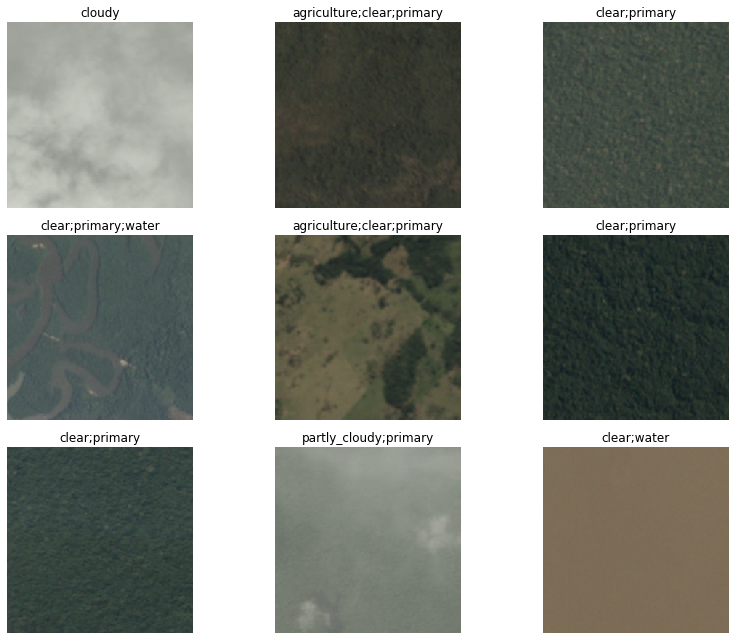

In [9]:
data.show_batch(rows=3, figsize=(12,9))

In [10]:
arch = models.resnet50
model_name = 'resnet50'

In [11]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

In [12]:
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

In [13]:
learn.load(model_name+'stage-2-256')

Learner(data=ImageDataBunch;

Train: LabelList (40479 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
haze;primary,agriculture;clear;primary;water,clear;primary,clear;primary,agriculture;clear;habitation;primary;road
Path: ../data;

Valid: LabelList (0 items)
x: ImageList

y: MultiCategoryList

Path: ../data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_si

In [14]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


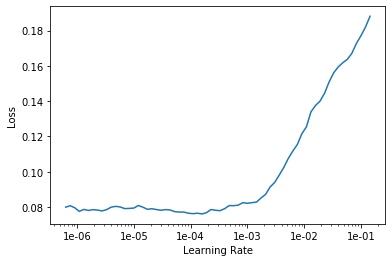

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
lr=1e-3/2

In [17]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

In [18]:
learn.save(model_name+'-training-data')

Now we can fine-tune the model using the test data with the predicted labels.

In [19]:
src = (ImageList.from_csv(path, 'test_labels.csv', folder='test-jpg', suffix='.jpg')
       .split_none()
       .label_from_df(label_delim=' '))

In [20]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [21]:
bs=64

In [22]:
data = (src.transform(tfms, size=256)
       .databunch(bs=bs).normalize(imagenet_stats))

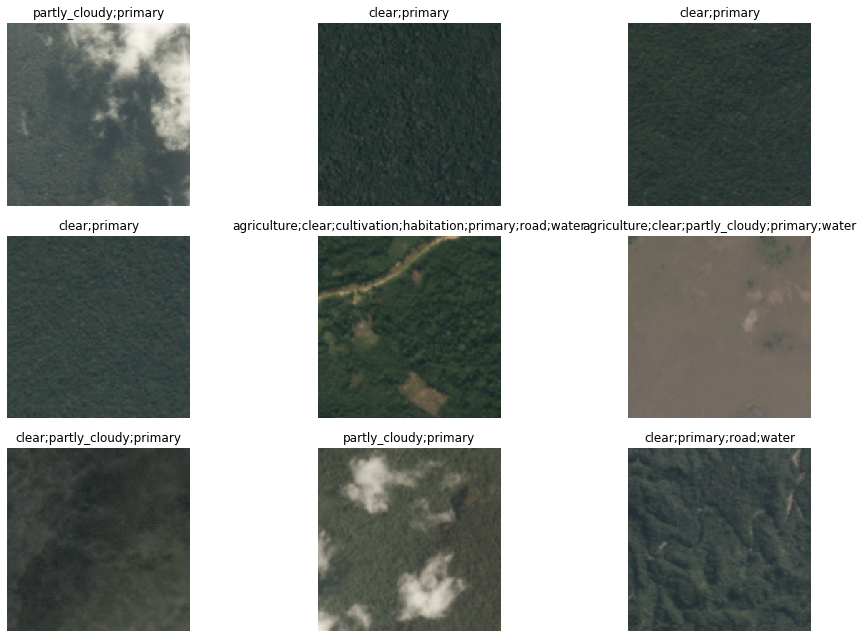

In [23]:
data.show_batch(rows=3, figsize=(12,9))

In [24]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


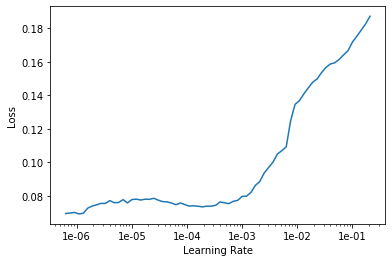

In [25]:
learn.lr_find()
learn.recorder.plot()

In [26]:
lr=1e-4/2

In [27]:
learn.fit_one_cycle(3, slice(1e-5, lr/5))

In [30]:
learn.save(model_name+'-all-data')

In [31]:
learn.export(model_name+'-all-data')